In [4]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import os
import seaborn as sns
import warnings
from scipy.stats import linregress

ModuleNotFoundError: No module named 'seaborn'

In [5]:
warnings.filterwarnings('ignore')

NameError: name 'warnings' is not defined

# Read in titles data files and create combined DataFrame

In [6]:
# Data files
netflix_path = "../data/netflix_titles.csv"
disney_path = "../data/disney_plus_titles.csv"

# Read the Netflix and Disney+ data
netflix_data = pd.read_csv(netflix_path)
disney_data = pd.read_csv(disney_path)


In [7]:
# Create Netflix dataframe and review length
netflix_df = pd.DataFrame(netflix_data)
len(netflix_df)

8807

In [8]:
# Netflix date_added is the key column for filtering to 2019 - 2021 to align with Disney+ dataset date_added dates
# The following steps trim the "September 24, 2018" dates to remove extra spaces
netflix_df['date_added'] = netflix_df['date_added'].str.strip()
# netflix_df['date_added'] = pd.to_datetime(netflix_df['date_added'], errors='coerce')

# There are a handful of blank date_added that will impact date filtering
netflix_blank_dates = netflix_df[netflix_df['date_added'].isna()]
len(netflix_blank_dates)

10

In [9]:
# Drop rows with blank dates
netflix_df = netflix_df.dropna(subset=['date_added'])

# Verify the number of rows with blank dates after dropping
len(netflix_df[netflix_df['date_added'].isna()])

0

In [10]:
# Extract only the date portion and convert it to string
netflix_df['date_added'] = pd.to_datetime(netflix_df['date_added'], errors='coerce')
netflix_df['date_added'] = netflix_df['date_added'].dt.date.astype(str)


In [11]:
# Filter out for dates greater than January 1, 2019
netflix_df = netflix_df.loc[(netflix_df['date_added'] >= '2019-01-01') & (netflix_df['date_added'] <= '2021-12-31')]
len(netflix_df)

5393

In [12]:
# Create Disney+ dataframe and review length
disney_df = pd.DataFrame(disney_data)
len(disney_df)

1450

In [13]:
# There are a handful of blank date_added that will impact data
disney_blank_dates = disney_df[disney_df['date_added'].isna()]
len(disney_blank_dates)

3

In [14]:
# Drop rows with blank dates
disney_df = disney_df.dropna(subset=['date_added'])

# Verify the number of rows with blank dates after dropping
len(disney_df[disney_df['date_added'].isna()])

0

In [15]:
# Extract only the date portion and convert it to string
disney_df['date_added'] = pd.to_datetime(disney_df['date_added'], errors='coerce')
disney_df['date_added'] = disney_df['date_added'].dt.date.astype(str)

In [16]:
# Add platform column to each streaming service to maintain association
netflix_df.loc[:, "platform"] = "Netflix"
disney_df.loc[:, "platform"] = "Disney+"


In [17]:
# Concatenate Netflix and Disney+ dataframes
combined_df = pd.concat([netflix_df, disney_df], ignore_index=True)
len(combined_df)

6840

In [18]:
# Find duplicate titles to remove from analysis
duplicate_titles = combined_df[combined_df.duplicated(subset=['title'])]
len(duplicate_titles)

22

In [19]:
# Extract the primary genre from listed_in by pulling the first values within the list
combined_df['listed_in'] = combined_df['listed_in'].str.split(',')
combined_df['primary_genre'] = combined_df['listed_in'].str.get(0)

# blank_genre = combined_df[combined_df['primary_genre'].isna()]
# len(blank_genre)

In [20]:
# Clean dataframe with columns of importance for data analysis
combined_df = combined_df.loc[:, ['title', 'type','release_year', 'primary_genre', 'platform', 'date_added']]

In [21]:
# Enter in field value replacements for genre normalization (i.e. Documentaries and Docuseries to Documentary)
data_iteration_1 = combined_df.replace(to_replace='Animation', value = 'Animated')
data_iteration_2 = data_iteration_1.replace(to_replace=['Docuseries', 'Documentaries'], value = 'Documentary')
data_iteration_3 = data_iteration_2.replace(to_replace=['Biographical', 'Historical'], value = 'Historical')
data_iteration_4 = data_iteration_3.replace(to_replace=['Thriller', 'Crime'], value = 'Thriller/Crime')
data_iteration_5 = data_iteration_4.replace(to_replace=['Stand-UpComedy&Talk', 'Comedies'], value = 'Comedy')
data_iteration_6 = data_iteration_5.replace(to_replace=['Stand-UpComedy', 'Buddy'], value = 'Comedy')
data_iteration_7 = data_iteration_6.replace(to_replace=['Classic Movies', 'Classic&Cult'], value = 'Classic/Cult/Independent')
data_iteration_8 = data_iteration_7.replace(to_replace='IndependentMovies', value = 'Classic/Cult/Independent')
data_iteration_9 = data_iteration_8.replace(to_replace=['Horror', 'HorrorMovies'], value = 'Horror')
data_iteration_10 = data_iteration_9.replace(to_replace=['Music&Musicals', 'ConcertFilm'], value = 'Music/Musicals')
data_iteration_11 = data_iteration_10.replace(to_replace=['Music', 'Musical'], value = 'Music/Musicals')
data_iteration_12 = data_iteration_11.replace(to_replace='Dance', value = 'Music/Musicals')
data_iteration_13 = data_iteration_12.replace(to_replace=['Family', 'Kids'], value = 'Family/Kids')
data_iteration_14 = data_iteration_13.replace(to_replace=["Kids'", 'Children&FamilyMovies'], value = 'Family/Kids')
data_iteration_15 = data_iteration_14.replace(to_replace=['ScienceFiction', 'Fantasy'], value = 'SciFi/Fantasy')
data_iteration_16 = data_iteration_15.replace(to_replace='Sci-Fi&Fantasy', value = 'SciFi/Fantasy')
data_iteration_17 = data_iteration_16.replace(to_replace=['Action-Adventure', 'Action&Adventure'], value = 'Action/Adventure')
data_iteration_18 = data_iteration_17.replace(to_replace=['International', 'InternationalMovies'], value = 'International')
data_iteration_19 = data_iteration_18.replace(to_replace='Dramas', value = 'Drama')
data_iteration_20 = data_iteration_19.replace(to_replace='Gameshow/Competition', value = 'Reality')
data_iteration_21 = data_iteration_20.replace(to_replace=['Movies', 'Series'], value = 'Behind the Scenes')
combined_df = data_iteration_21.replace(to_replace='Anthology', value = 'Behind the Scenes')


In [22]:
#Display unique count of genres
genres = combined_df['primary_genre'].unique()
len(genres)

50

In [23]:
# Convert 'date_added' column to datetime
combined_df['date_added'] = pd.to_datetime(combined_df['date_added'])
# Extract year from 'date_added' and store it in a new column 'year_added'
combined_df['year_added'] = combined_df['date_added'].dt.year

combined_df.head()

,title,type,release_year,primary_genre,platform,date_added,year_added
0,Dick Johnson Is Dead,Movie,2020,Documentary,Netflix,2021-09-25,2021
1,Blood & Water,TV Show,2021,International TV Shows,Netflix,2021-09-24,2021
2,Ganglands,TV Show,2021,Crime TV Shows,Netflix,2021-09-24,2021
3,Jailbirds New Orleans,TV Show,2021,Documentary,Netflix,2021-09-24,2021
4,Kota Factory,TV Show,2021,International TV Shows,Netflix,2021-09-24,2021


# Genre and Type composition plotting

In [26]:
# Convert 'date_added' column to datetime
combined_df['date_added'] = pd.to_datetime(combined_df['date_added'])
# Extract year from 'date_added' and store it in a new column 'year_added'
combined_df['year_added'] = combined_df['date_added'].dt.year

combined_df.head()

,title,type,release_year,primary_genre,platform,date_added,year_added
0,Dick Johnson Is Dead,Movie,2020,Documentary,Netflix,2021-09-25,2021
1,Blood & Water,TV Show,2021,International TV Shows,Netflix,2021-09-24,2021
2,Ganglands,TV Show,2021,Crime TV Shows,Netflix,2021-09-24,2021
3,Jailbirds New Orleans,TV Show,2021,Documentary,Netflix,2021-09-24,2021
4,Kota Factory,TV Show,2021,International TV Shows,Netflix,2021-09-24,2021


# Genre and Type composition plotting

AttributeError: 'function' object has no attribute 'show'

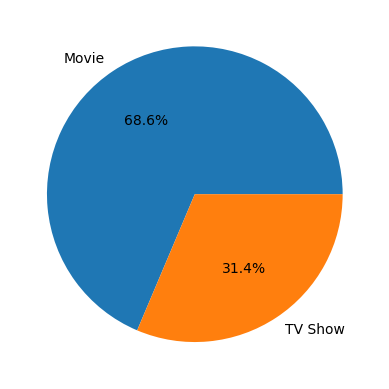

In [82]:
# Netflix pie chart for movie/tv shows (1692 tv shows, 3701 movies)
netflix_movie = combined_df.loc[(combined_df['type'] == 'Movie') & (combined_df['platform'] == 'Netflix')]
netflix_tv_show = combined_df.loc[(combined_df['type'] == 'TV Show') & (combined_df['platform'] == 'Netflix')]
labels = 'Movie', 'TV Show'
sizes = [3701, 1692]
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
ax.pie.show()

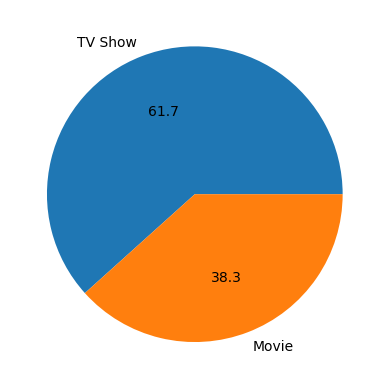

In [88]:
# Disney pie chart for movie/tv shows (1052 /395
netflix_tv_show = combined_df.loc[(combined_df['type'] == 'TV Show') & (combined_df['platform'] == 'Netflix')]
netflix_movie = combined_df.loc[(combined_df['type'] == 'Movie') & (combined_df['platform'] == 'Disney+')]
labels = 'TV Show', 'Movie'
sizes = [1692, 1052]
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f')
plt.show()

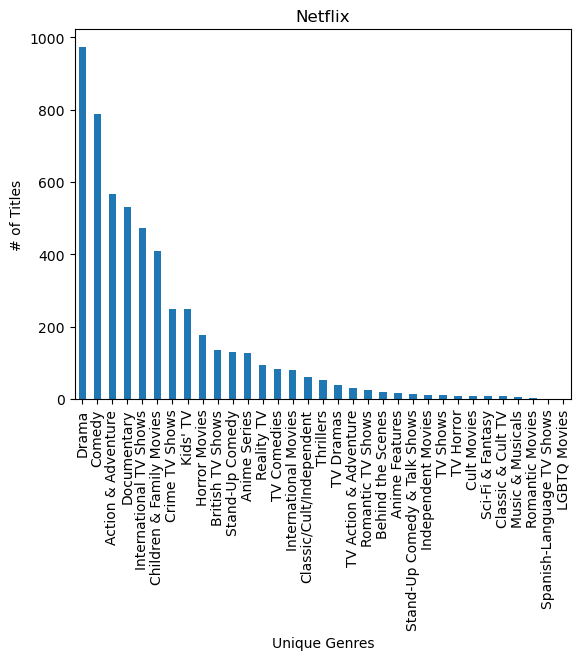

In [89]:
# Netflix bar chart for primary genre counts
netflix_bar_chart = combined_df.loc[combined_df['platform'] == 'Netflix']
netflix_bar_chart = netflix_bar_chart["primary_genre"].value_counts()
netflix_bar_chart.plot.bar(xlabel = 'Unique Genres', ylabel='# of Titles', title='Netflix')
plt.show()

<Axes: title={'center': 'Disney+'}, xlabel='Unique Genres', ylabel='# of Titles'>

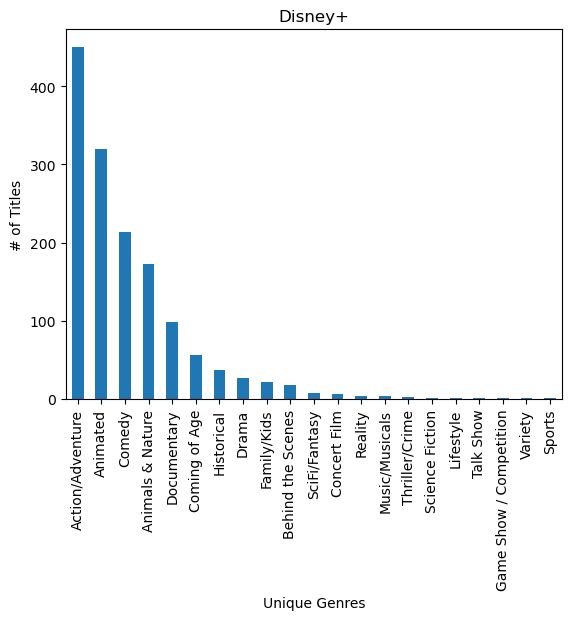

In [81]:
# Disney bar chart for primary genre counts
disney_bar_chart = combined_df.loc[combined_df['platform'] == 'Disney+']
disney_bar_chart = disney_bar_chart["primary_genre"].value_counts()
disney_bar_chart.plot.bar(xlabel = 'Unique Genres', ylabel='# of Titles', title='Disney+')
plt.show()

# Release year plotting

In [ ]:
# Netflix bar or line chart for release years

In [24]:
# Disney bar or line chart for release years

# Read in price data file and create DataFrame

In [ ]:
# Create Subscription Price dataframe and review length
prices_path = "../data/subscription_prices.csv"
prices_data = pd.read_csv(prices_path)
prices_df = pd.DataFrame(prices_data)
len(prices_df)

# Subscription Price plotting

In [26]:
# Line chart for subscription prices

# Create DataFrame for most recently added titles

In [ ]:
# Sorted data frames by date_added
sorted_netflix_df = netflix_df.sort_values(by = 'date_added', ascending=False)
sorted_disney_df = disney_df.sort_values(by = 'date_added', ascending=False)

In [ ]:
# Most recently added 500 titles per platform
recentadd_netflix_df = sorted_netflix_df.head(600)
recentadd_disney_df = sorted_disney_df.head(600)

In [ ]:
# Concatenate recentadd Netflix and Disney+ dataframes
recentadd_df = pd.concat([recentadd_netflix_df, recentadd_disney_df], ignore_index=True)
len(recentadd_df)

1000

In [30]:
# Extract the primary genre from listed_in by pulling the first values within the list
recentadd_df['listed_in'] = recentadd_df['listed_in'].str.split(',')
recentadd_df['primary_genre'] = recentadd_df['listed_in'].str.get(0)

In [31]:
# Clean dataframe with columns of importance for data analysis
recentadd_df = recentadd_df.loc[:, ['title', 'type','release_year', 'primary_genre', 'platform', 'date_added']]

In [ ]:
# Add empty columns for IMDb metadata to be pulled from API
recentadd_df['imdb_id'] = ''
recentadd_df['imdb_rating'] = ''
recentadd_df['imdb_votes'] = ''
recentadd_df['box_office_sales'] = ''
recentadd_df['production_cost'] = ''

# Call OMDB API to pull metadata into DataFrame / Save output

In [ ]:
# Import the OMDB API key
from api_keys import omdb_api_key

In [35]:
# TEST
# Response 200 testing
# url = "http://www.omdbapi.com/?t="
# api_key = "&apikey=" + omdb_api_key
# response = requests.get(url + "Aliens" + api_key, verify=False)
# print(response)

In [36]:
# TEST
# Printing API URLs out

# Establishing base URL for OMDB API
# url = "http://www.omdbapi.com/"

# Construct the API request URL with the title and API key
# params = {
#        'apikey': omdb_api_key,
#    }

# Loop through each title in the 'title' column of combined_df
# for index, row in combined_df.iterrows():
#    time.sleep(2) # Add a delay to avoid hitting the API too quickly
    
#    title = row['title']
#    params['t'] = title # get title from combined_df
    
# Construct the API URL
#    api_url = url + "?" + "&".join([f"{key}={value}" for key, value in params.items()])

# Print the API URL for the current title
#    print("API URL for", title, ":", api_url)


In [ ]:
# Establishing base URL for OMDB API
url = "http://www.omdbapi.com/"

# Construct the API request URL with the title and API key
params = {
        'apikey': omdb_api_key,
    }

# Loop through each title in the 'title' column of combined_df
for index, row in recentadd_df.iterrows():
    time.sleep(1) # Add a delay to avoid hitting the API too quickly
    
    title = row['title'] # get title from current row
    params['t'] = title # establish "t" parameter for current title
 
   # Run an API request for each of the titles
    try:
        # Parse the JSON and retrieve data
        omdb_response = requests.get(url, params=params, verify=False)
        omdb_data = omdb_response.json()
    
    # Parse out OMDB ratings, votes, etc.
        id = omdb_data.get('imdbID')
        rating = omdb_data.get('imdbRating')
        votes = omdb_data.get('imdbVotes')
        box_office_sales = omdb_data.get('BoxOffice')
        prod_cost = omdb_data.get('Production')
        
    # Assign OMDB information into combined_df
        recentadd_df.at[index, "imdb_id"] = id
        recentadd_df.at[index, "imdb_rating"] = rating
        recentadd_df.at[index, "imdb_votes"] = votes 
        recentadd_df.at[index, "box_office_sales"] = box_office_sales 
        recentadd_df.at[index, "production_cost"] = prod_cost

                             
        print(f"Data retrieved for '{title}': imdbRating = {rating}, imdbVotes = {votes}")
    except Exception as e:
        print(f"Failed to fetch data for '{title}': {e}")

In [ ]:
# Show record count
recentadd_df.count()

In [ ]:
# Display new DataFrame with new OMDB metadata
recentadd_df.head()

In [ ]:
# Export the recentadd_rated_df into a csv
recentadd_df.to_csv("../output/recentadd_rated2.csv", index_label="index")

# Read in ratings data file and create DataFrame

In [ ]:
# New ratings file
new_data_path = "../output/recentadd_rated2.csv"

In [ ]:
# Read the new Netflix and Disney+ data
new_combined_data = pd.read_csv(new_data_path)
new_combined_df= pd.DataFrame(new_combined_data)
new_combined_df

In [ ]:
# Find "None" and "N/A" values for each platform

In [ ]:
# Remove "None" and "N/A" values to create clean dataframe

In [ ]:
# out of 1000 rows 998 blank  for production_cost
blank_production_cost = new_combined_df[new_combined_df['production_cost'].isna()]
len(blank_production_cost)

# Generate Summary Statistics for each platform

In [ ]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM for each platform
# Use groupby and summary statistical methods to calculate the following properties of each platform: 

In [ ]:
# Generate a box plot that shows the distrubution of IMDB rating for each platform.
plt.figure(figsize=(10, 6))
sns.boxplot(data=new_combined_df, x='platform', y='imdb_rating')
plt.title('Box Plot of IMDb Ratings by Platform')
plt.xlabel('Platform')
plt.ylabel('IMDB Rating')
plt.xticks(rotation=45)
# Save the plot to the output folder
plt.savefig(os.path.join('../output', 'BoxPlot_of_IMDbRatings_Platform.png'))
plt.show()

In [ ]:
# # change production_cost dtype to float
# combined_df['production_cost'] = combined_df['production_cost'].astype(float)

In [ ]:
# # Group by 'platform' and calculate the average production cost for each platform
# average_production_cost_per_platform = new_combined_df.groupby('platform')['production_cost'].mean()

# # Plot the bar chart
# average_production_cost_per_platform.plot(kind='bar', figsize=(10, 6), color='skyblue')

# # Set the title and labels
# plt.title('Average Production Cost per Platform')
# plt.xlabel('Platform')
# plt.ylabel('Average Production Cost')

# # Show the plot
# plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
# plt.tight_layout()  # Adjust layout to prevent clipping of labels
# plt.savefig(os.path.join('../output', 'Average_Production_Cost_per_Platform.png'))
# plt.show()